# The Classification of Pulsar Stars - Project Report
**By Oliver Gullery, Chan Le, Simon Lin, and Adam Parolin**

### Introduction

Pulsar stars are a rare type of neutron star that produce detectable radio emissions. Pulsars rotate and emit beams of electromagnetic radiation, which can be detected if they align directly with Earth. 

These beams take the form of radio waves - electromagnetic waves oscillating at specific frequencies that can be detected.

Using scientific equipment, we can scan for radio waves and discover new pulsar stars. However, some positive detections are caused by radio frequency interference, which makes real detections difficult to find. The main objective of our data analysis is determining if scientific equipment analyzed a real pulsar star or radio frequency interference.<br/> 

<img src="https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif

This leads into our question: 
__Using pulsar star candidate data recorded by scientific equipment, is a given candidate a true pulsar star or just radio frequency interference?__

Each observation in the data set (the <a href="https://archive.ics.uci.edu/ml/datasets/HTRU2">HTRU2 Data Set</a> by Rob Lyon) is a candidate, with 8 continuous variables:<br />
1. `mean_of_int_profiles` <br/>
2. `sd_of_int_profiles`<br />
3. `excess_kurtosis_of_int_profiles`<br />
4. `skewness_of_int_profiles`<br />
5. `mean_of_curve`<br />
6. `sd_of_curve`<br />
7. `excess_kurtosis_of_curve`<br />
8. `skewness_of_curve`<br />

... and one class variable:<br />
1. `true_pulsar`



### Method and Results

In [ ]:
# Importing required libraries

library(tidyverse)
library(repr)
library(tidymodels)

We can download the dataset (https://archive.ics.uci.edu/ml/datasets/HTRU2) and import into JupyterHub.

In [ ]:
# Downloading from url 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
dir.create("data")
file <- download.file(url, "data/HTRU2.zip")

# Because the data we need is in a .zip file, we use the unzip() function in order to access "HTRU_2.csv"
star_data <- read_csv(unzip("data/HTRU2.zip", files = "HTRU_2.csv", exdir = "data/"), 
            col_names = c("mean_of_int_profiles", "sd_of_int_profiles", "excess_kurtosis_of_int_profiles",
            "skewness_of_int_profiles", "mean_of_curve", "sd_of_curve", 
            "excess_kurtosis_of_curve", "skewness_of_curve", "true_pulsar")) |>
    mutate(true_pulsar = as_factor(true_pulsar))
slice(star_data, 1:10)
# Below is a snapshot of the star data we will be working with

The first step is to split our data into a training and a testing set:

In [ ]:
# DO NOT REMOVE
set.seed(9999) 

# Splitting data into training and testing, with true_pulsar as the strata
pulsar_split <- initial_split(star_data, prop = 0.75, strata = true_pulsar)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

#### Preliminary Exploratory Data Analysis

Before we begin classification, we will first take a closer look at our training data.

In [ ]:
# Summarizing data into table counting the number of true and false pulsars
pulsar_frequency <- pulsar_train |>
    group_by(true_pulsar) |>
    summarize(number = n())
pulsar_frequency

In [ ]:
# Creating another table that shows the average of our intended predictor variables
pulsar_predictors <- pulsar_train |>
    group_by(true_pulsar) |>
    summarize(avg_mean_of_int_profiles = mean(mean_of_int_profiles),
              avg_mean_of_curve = mean(mean_of_curve))

pulsar_predictors

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9708707,3,0.001809886,Preprocessor1_Model01
6,accuracy,binary,0.9784695,3,0.002099335,Preprocessor1_Model02
11,accuracy,binary,0.9785441,3,0.001397186,Preprocessor1_Model03
16,accuracy,binary,0.9783950,3,0.001645533,Preprocessor1_Model04
21,accuracy,binary,0.9783206,3,0.001522761,Preprocessor1_Model05
26,accuracy,binary,0.9782461,3,0.001665636,Preprocessor1_Model06
31,accuracy,binary,0.9779481,3,0.001594082,Preprocessor1_Model07
36,accuracy,binary,0.9777991,3,0.001614906,Preprocessor1_Model08
41,accuracy,binary,0.9780226,3,0.001809414,Preprocessor1_Model09


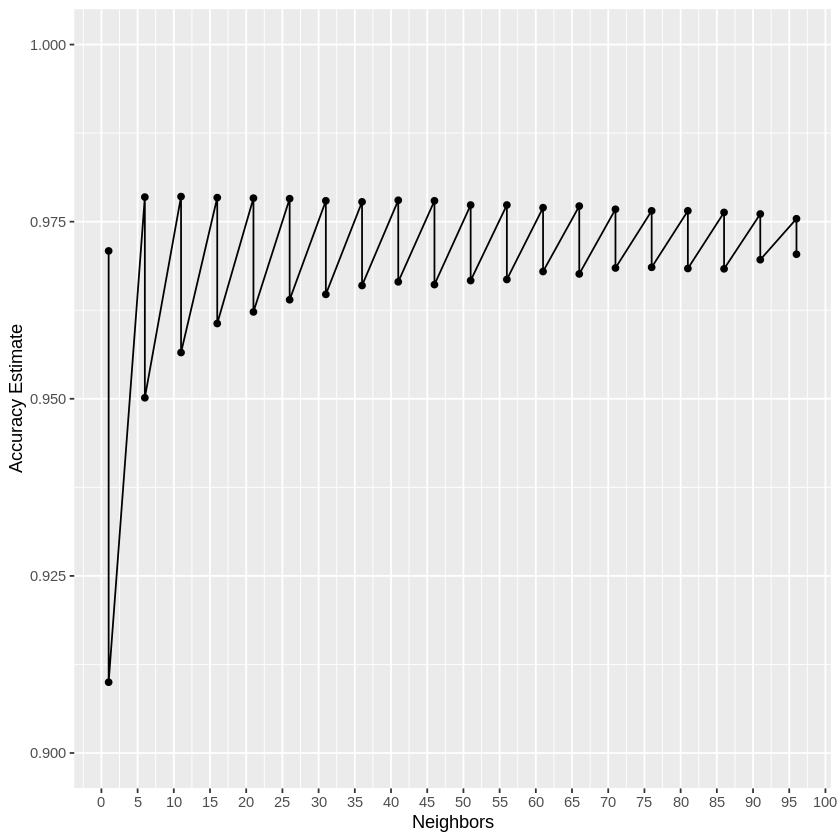

In [6]:
# visualisations 
# finding optimal value of k
pulsar_recipe <- recipe(true_pulsar ~., data = pulsar_train)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |> 
    set_mode("classification") 

knn_spec
pulsar_vfold <- vfold_cv(pulsar_train, v = 3, strata = true_pulsar)  # note: value of v, wouldn't run above 5


k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(pulsar_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
  collect_metrics() 


# max_accuracy <- knn_results |> summarise(max_acc = max(accuracy))
# max_accuracy

accuracies <- knn_results |> 
      filter(.metric == "accuracy")
accuracies
accuracy_versus_k <- ggplot(knn_results, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 100, by = 5)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.9, 1.0)) # adjusting the y-axis

accuracy_versus_k # the highest accuracy was associated with a k-value of 26
# Through this summary table, we found that the number of neighbors k did not have a significant impact of the accuracy of our results as from a range of roughly
# 1 - 36 the accuracy remains around 0.978


In [7]:


pulsar_training_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 26) |> set_engine("kknn") |> set_mode("classification") 


pulsar_fit <- workflow() |>
      add_recipe(pulsar_recipe) |>
      add_model(pulsar_training_model) |>
      fit(data = pulsar_train)

pulsar_test_predictions <- predict(pulsar_fit, pulsar_test) |> bind_cols(pulsar_test) # prediction set

pulsar_prediction_accuracy <- pulsar_test_predictions |> metrics(truth = true_pulsar, estimate = .pred_class) # accuracy of predictions

pulsar_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9747486
kap,binary,0.8404978


In [8]:
pulsar_mat <- pulsar_test_predictions |> 
      conf_mat(truth = true_pulsar, estimate = .pred_class)
pulsar_mat # using this matrix we find that 4,362 our of 4,475 of our observations were labelled correctly

          Truth
Prediction    0    1
         0 4031   92
         1   21  331

In [9]:
pulsar_predictions_with_labels <- pulsar_test_predictions |>
      select(.pred_class) |>
      bind_cols(pulsar_test |> select(-X)) |>
      mutate(seq = 1:nrow(pulsar_test)) |>
      as.data.frame()

matching <- pulsar_predictions_with_labels |>
         filter(.pred_class == true_pulsar) |>
         sample_n(3) |>

matching1 <- matching |>
         slice(1) |>
         select(seq) |>
         pull()

matching2 <- matching |>
         slice(1) |>
         select(seq) |>
         pull()

matching3 <- matching |>
         slice(2) |>
         select(seq) |>
         pull()

show_digit(slice(pulsar_test, matching_1))
show_digit(slice(pulsar_test, matching_2))
show_digit(slice(pulsar_test, matching_3))

ERROR: Error in parse(text = x, srcfile = src): The pipe operator requires a function call as RHS


In [ ]:
Description of Methodology: We used cross-validation to determin the most accurate k number of neighbors. We then used this value to determine the accuracy of our 
test set.

We used a K nearest neighbour classifier, this is a type of supervised learning method. The knn algorithmn uses proximity to make classifications or predictions 
about the grouping of a particular datapoint. We used cross-validation to determine the most accurate k number of neighbors, which was 21. We subsequently used this
value to determine the accuracy of the our test set, which was 0.9747486. 

K nearest neighbour classifier:
k-NN is a type of instance-based learning, or lazy learning, where the function is only
approximated locally and all computation is deferred until classification. The k-NN algorithm
is among the simplest of all machine learning algorithms.
The neighbours are taken from a set of objects for which the class (for k-NN classification) or
the object property value (for k-NN regression) is known. This can be thought of as the
training set for the algorithm, though no explicit training step is required.

## Predictor variable selection

In [ ]:
# create an empty tibble to store the results

star_data_true <- star_data

star_data <- rep_sample_n(star_data, size = 20)

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
star_vfold <- vfold_cv(star_data, v = 5, strata = true_pulsar)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("true_pulsar", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        star_recipe <- recipe(as.formula(model_string), 
                                data = star_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(star_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = star_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

### Discussion

__What did we find?__

__Is this what we expected to find?__

__What are the impacts of this finding?__
With the ability to confidently classify whether a star is pulsar or not, scientists could make enourmous strides in astronomy. By weeding out the fake pulsars and focusing only on the real ones, scientists can more accurately study what is happening inside real pulsars. Since neutron stars (which pulsars are) are the densest material in the universe, studying them can lead to enourmous discoveries related to the physics of the universe. Also, by weeding out the fake pulsars, scientists can focus in on the real pulsars and calculate cosmic distances.  This is because pulsar stars blink at regular intervals rivaled only by atomic clocks (https://www.space.com/32661-pulsars.html).  Overall, the ability to accurately predict whether a "pulsar event" in data is real or just interference is a major step in studying the universe beyond our own planet.

__What future questions are there?__
One big question is can this be applied to universes outside our own? If there are pulsar stars in our universe, there are likely stars like this in others.  Would the same algorithm for finding these stars apply outside our own universe?

Also, we must question if there are more accurate predictor variables that would work better? This also brings up, can we tune equipement in the field to also track in real time whether a reading is real or interference and filter it right away so scientists don't need to study it?

Given that this is just a predictive algorithm to determine if it is pulsar or interference, we must question the validity of the data and if the scientists behind it accurately classified the pulsars.

### References